In [44]:
# Import Libraries

In [45]:
import os
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Conv2D, MaxPooling2D, 
    Embedding, Dropout
)
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
import logging
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from collections import Counter
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [46]:
# Dataset paths

train_path = "Dataset-HAR-Monitoring/train.csv"
test_path = "Dataset-HAR-Monitoring/test.csv"

In [47]:
# Load Data

In [48]:
def load_data(train_path, test_path):
    """Load train and test datasets."""
    
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

In [49]:
# Define target_names
target_names = ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

In [50]:
# EDA Check

In [51]:
def EDA_check(train, test):
    """Perform exploratory data analysis."""
    print("\n--- Performing EDA ---")
    data_overview(train, test)
    basic_statistics(train)
    class_distribution(train)
    missing_data(train)
    feature_relationships(train)
    feature_distributions(train)

In [52]:
# Sub Methods for EDA

In [53]:
# Data Overview

def data_overview(train, test):
    """Display basic information about the datasets."""
    print("\n--- TRAIN DATA OVERVIEW ---")
    print(train.info())
    print(train.head())
    print("Shape:", train.shape)

    print("\n--- TEST DATA OVERVIEW ---")
    print(test.info())
    print(test.head())
    print("Shape:", test.shape)

In [54]:
# Basic stats

def basic_statistics(train):
    """Display basic statistics and column information."""
    print("\n--- BASIC STATISTICS ---")
    print(train.describe())
    print("\nUnique values per column:")
    print(train.nunique())

    cat_cols = train.select_dtypes(include=['object']).columns
    num_cols = train.select_dtypes(include=['float64', 'int64']).columns
    print("\nCategorical Columns:", cat_cols)
    print("\nNumerical Columns:", num_cols)


In [55]:
# Class Distribution

def class_distribution(train):
    """Plot the distribution of target classes."""
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Activity', data=train)
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

In [56]:
# Identify missing data 

def missing_data(train):
    """Check for missing values and duplicates."""
    print("\n--- MISSING DATA ---")
    missing = train.isnull().sum()
    print(missing[missing > 0])

    print("\n--- DUPLICATES ---")
    duplicates = train.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")

In [57]:
# Feature Correlation Matrix

def feature_relationships(train):
    """Plot feature correlation matrix."""
    numeric_train = train.select_dtypes(include=['float64', 'int64'])
    correlation_matrix = numeric_train.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, linewidths=0.1)
    plt.title('Feature Correlation Matrix')
    plt.show()

In [58]:
# Feature Distribution

def feature_distributions(train):
    """Plot feature distributions."""
    num_features = train.shape[1]
    features_per_plot = 100  # Number of features per subplot
    num_plots = int(np.ceil(num_features / features_per_plot))

    # Plot histograms in batches
    for i in range(num_plots):
        start_col = i * features_per_plot
        end_col = min((i + 1) * features_per_plot, num_features)

        train.iloc[:, start_col:end_col].hist(figsize=(16, 12), bins=30)
        plt.suptitle(f'Feature Distribution (Columns {start_col+1} to {end_col})')
        plt.show()

    # Plot boxplots in smaller groups
    boxplot_features = 100  # Number of features per boxplot
    num_boxplots = int(np.ceil(num_features / boxplot_features))

    for i in range(num_boxplots):
        start_col = i * boxplot_features
        end_col = min((i + 1) * boxplot_features, num_features)

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=train.iloc[:, start_col:end_col])
        plt.title(f'Boxplot of Features {start_col+1} to {end_col}')
        plt.xticks(rotation=90)
        plt.show()

In [59]:
# Data Preprocessing

In [60]:
from sklearn.preprocessing import OneHotEncoder

def data_preprocessing(train, test):
    """Preprocess data: scaling, PCA, and feature selection."""
    print("\n--- Preprocessing Data ---")
    X_train, X_test = remove_highly_correlated_features(train, test)
    X_train, X_test, vif_data = remove_high_vif_features(X_train, X_test)

    # Separate features and target
    X_train_cleaned = X_train.drop(columns=['Activity'], errors='ignore')
    X_test_cleaned = X_test.drop(columns=['Activity'], errors='ignore')

    # Encode the 'subject' column using OneHotEncoding
    subject_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_train_subject_encoded = subject_encoder.fit_transform(X_train[['subject']])
    X_test_subject_encoded = subject_encoder.transform(X_test[['subject']])

    # Drop the original 'subject' column
    X_train_cleaned = X_train_cleaned.drop(columns=['subject'], errors='ignore')
    X_test_cleaned = X_test_cleaned.drop(columns=['subject'], errors='ignore')

    # Apply scaling and PCA
    X_train_scaled, X_test_scaled, scaler, pca = preprocess_data(X_train_cleaned, X_test_cleaned)

    # Combine scaled features with encoded subject data
    X_train_final = np.hstack((X_train_scaled, X_train_subject_encoded))
    X_test_final = np.hstack((X_test_scaled, X_test_subject_encoded))

    # Encode target variable
    activity_encoder = LabelEncoder()
    y_train = activity_encoder.fit_transform(X_train['Activity'])
    y_test = activity_encoder.transform(X_test['Activity'])

    # Check class imbalance before SMOTE
    check_class_imbalance(y_train, activity_encoder)

    # Handle class imbalance
    X_resampled, y_resampled = handle_class_imbalance(X_train_final, y_train)

    return X_resampled, y_resampled, X_test_final, y_test, scaler, pca, activity_encoder, subject_encoder

In [61]:
# Remove correletaed Features

In [62]:
def remove_highly_correlated_features(train, test, threshold=0.97):
    """Remove features with correlation above the threshold."""
    activity_train = train['Activity'] if 'Activity' in train.columns else None
    subject_train = train['subject'] if 'subject' in train.columns else None
    activity_test = test['Activity'] if 'Activity' in test.columns else None
    subject_test = test['subject'] if 'subject' in test.columns else None

    numeric_train = train.select_dtypes(include=['float64', 'int64'])
    X_train = numeric_train.drop(columns=['subject', 'Activity'], errors='ignore')

    corr_matrix = X_train.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    print(f"Removing {len(to_drop)} highly correlated features: {to_drop}")

    X_train = X_train.drop(columns=to_drop)
    X_test = test.drop(columns=to_drop, errors='ignore')

    if activity_train is not None:
        X_train['Activity'] = activity_train
    if subject_train is not None:
        X_train['subject'] = subject_train
    if activity_test is not None:
        X_test['Activity'] = activity_test
    if subject_test is not None:
        X_test['subject'] = subject_test

    return X_train, X_test

In [63]:
# Remove High VIF Features

def remove_high_vif_features(train, test, threshold=10):
    """Remove features with high VIF."""
    activity_train = train['Activity'] if 'Activity' in train.columns else None
    subject_train = train['subject'] if 'subject' in train.columns else None
    activity_test = test['Activity'] if 'Activity' in test.columns else None
    subject_test = test['subject'] if 'subject' in test.columns else None

    numeric_train = train.select_dtypes(include=['float64', 'int64'])
    X = numeric_train.drop(columns=['subject', 'Activity'], errors='ignore').copy()

    vif_values = svd_vif(X)
    vif_data = pd.DataFrame({"Feature": X.columns, "VIF": vif_values})
    vif_data = vif_data.sort_values(by="VIF", ascending=False)

    high_vif_features = vif_data[vif_data['VIF'] > threshold]['Feature'].tolist()
    print(f"Dropping {len(high_vif_features)} features with VIF > {threshold}: {high_vif_features}")

    train_reduced = train.drop(columns=high_vif_features, errors='ignore')
    test_reduced = test.drop(columns=high_vif_features, errors='ignore')

    return train_reduced, test_reduced, vif_data


def svd_vif(X):
    """Compute VIF using Singular Value Decomposition."""
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    vif_values = 1 / (s ** 2)
    return vif_values


In [64]:
# Preprocessor Data , scaling, PCA, and feature selection

In [65]:
def preprocess_data(X_train, X_test, variance_threshold=0.97):
    # Normalize features
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # Apply PCA
    pca = PCA(n_components=variance_threshold)  # Retain 97% variance
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Use original feature names for PCA components
    loadings = pd.DataFrame(pca.components_, columns=X_train.columns)

    # Create descriptive names for each principal component using all contributing features
    feature_names = ["_".join(loadings.iloc[i].index.tolist()) for i in range(loadings.shape[0])]

    # Assign human-readable column names
    X_train_pca = pd.DataFrame(X_train_pca, columns=feature_names)
    X_test_pca = pd.DataFrame(X_test_pca, columns=feature_names)

    return X_train_pca, X_test_pca, scaler, pca

In [66]:
# Check class imbalance

In [67]:
def check_class_imbalance(y_train, encoder):
    """Checks and visualizes class imbalance with actual activity names."""
    label_counts = pd.Series(y_train).value_counts()

    # Convert numeric labels back to original activity names
    activity_labels = encoder.inverse_transform(label_counts.index)

    # Define colors for the pie chart
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'pink', 'purple']

    # Plot class distribution with activity names
    plt.figure(figsize=(6, 6))
    plt.pie(label_counts, labels=activity_labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title("Distribution of Activity Classes")
    plt.show()

    return label_counts

In [68]:
# Handle class imbalance

In [69]:
def handle_class_imbalance(X_train, y_train):
    """Apply SMOTE to handle class imbalance."""
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [70]:
def tune_hyperparameters(X_train, y_train):
    #Perform hyperparameter tuning using GridSearchCV.

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [86]:
def randomforest_model_training_and_evaluation(algorithm_name, X_train, y_train, X_test, y_test):

#  Train and evaluate a Random Forest model.
# model (RandomForestClassifier): Trained Random Forest model.

    print(f"\n--- Training and Evaluating {algorithm_name} Model ---")

    # Hyperparameter tuning
    best_model = tune_hyperparameters(X_train, y_train)

    # Initialize the model with the best hyperparameters
    model = RandomForestClassifier(
        n_estimators=best_model.n_estimators,
        max_depth=best_model.max_depth,
        min_samples_split=best_model.min_samples_split, random_state=42, class_weight="balanced"
    )
    print(f"{algorithm_name} model initialized with tuned hyperparameters.")

    # Perform cross-validation
    logging.info("Performing cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-validation accuracy scores: {cv_scores}")
    print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

    # Initialize the model
    print(f"{algorithm_name} model trained on the full training set.")

    # Train the model
    model.fit(X_train, y_train)
    print("Model trained.")

    # Make predictions
    y_pred_random_forest = model.predict(X_test)
    print("Predictions made on the test set.")

    # Evaluate model performance
    evaluate_model(algorithm_name, y_test, y_pred_random_forest)
    print("Model evaluated.")
    return model,y_pred_random_forest

In [87]:
def plot_confusion_matrix(cm, y_test):
  #  Plot and save the confusion matrix.

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [88]:
def evaluate_model(algorithm_name, y_test, y_pred):

    # Evaluate the model's performance on the test set.

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print evaluation metrics
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test F1-score: {f1:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print("\nClassification Report:\n" + report)

    # Plot confusion matrix
    plot_confusion_matrix(cm, y_test)
    return accuracy, report, cm

In [89]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [90]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [76]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [77]:
# DATA LOADING

# EDA Check

# Data Preprocessing

In [78]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [79]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [80]:
# -----------------------------------------------------------------------------------------------------------------------------------


--- Performing EDA ---

--- TRAIN DATA OVERVIEW ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB
None
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944  

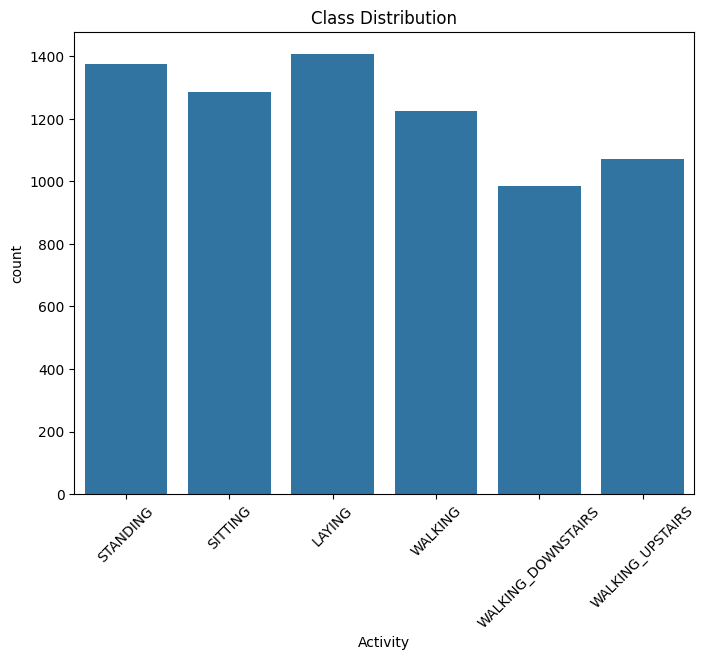


--- MISSING DATA ---
Series([], dtype: int64)

--- DUPLICATES ---
Number of duplicate rows: 0


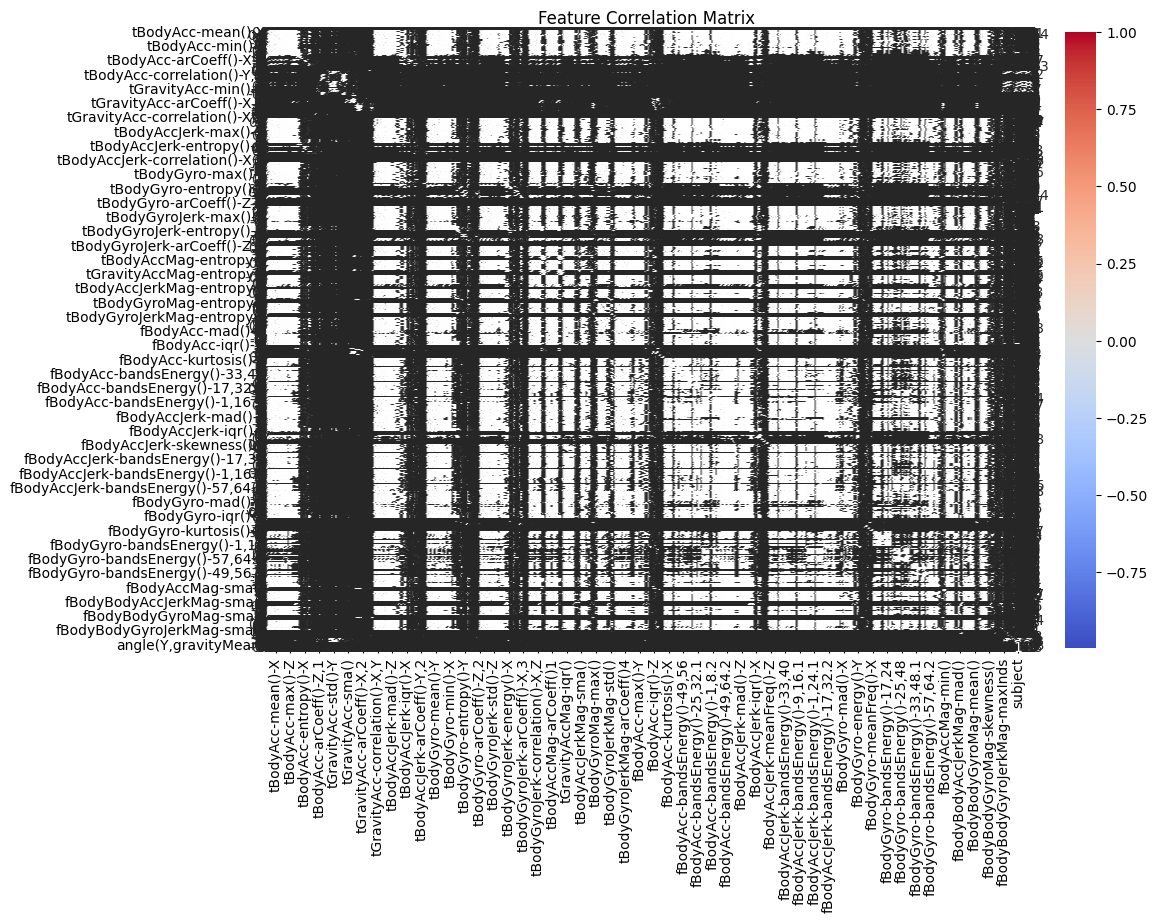

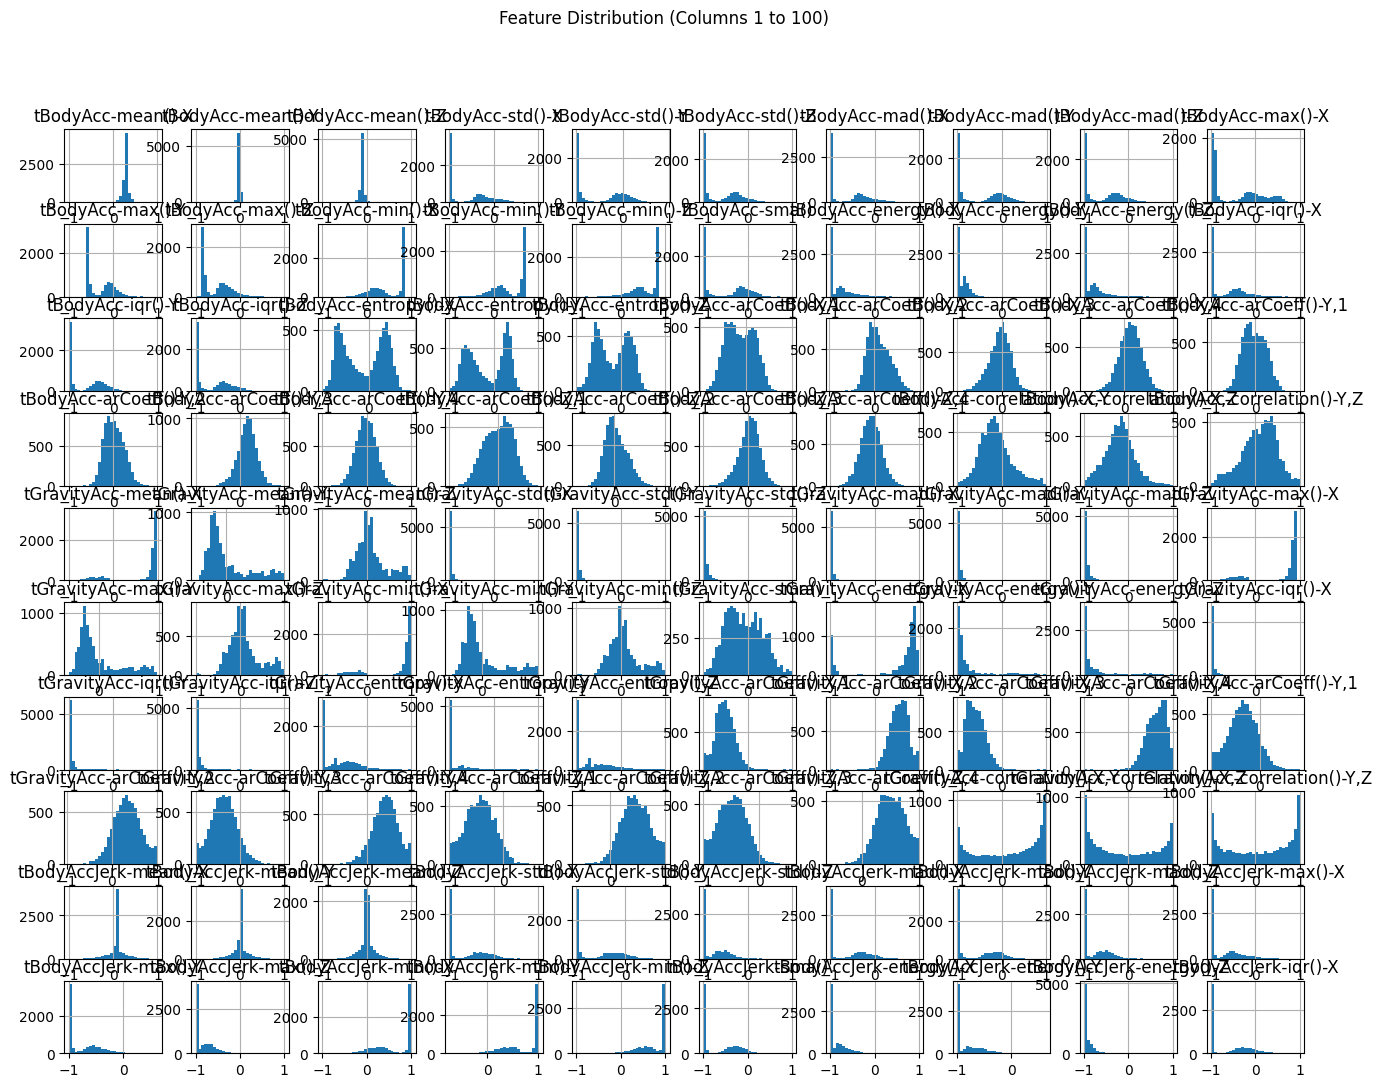

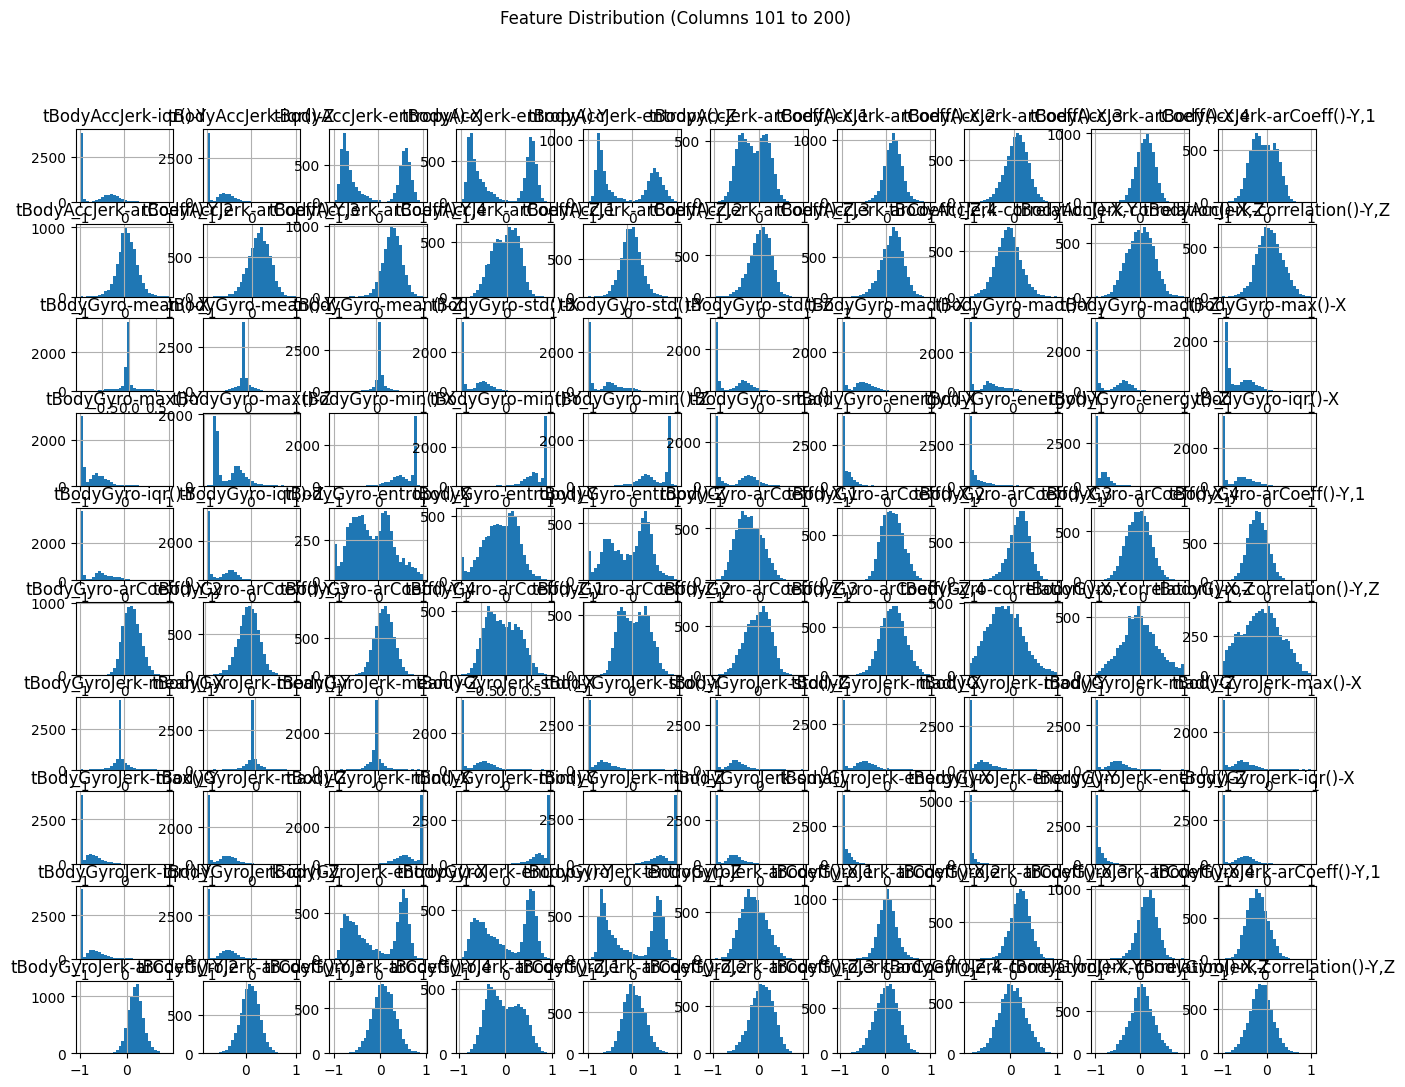

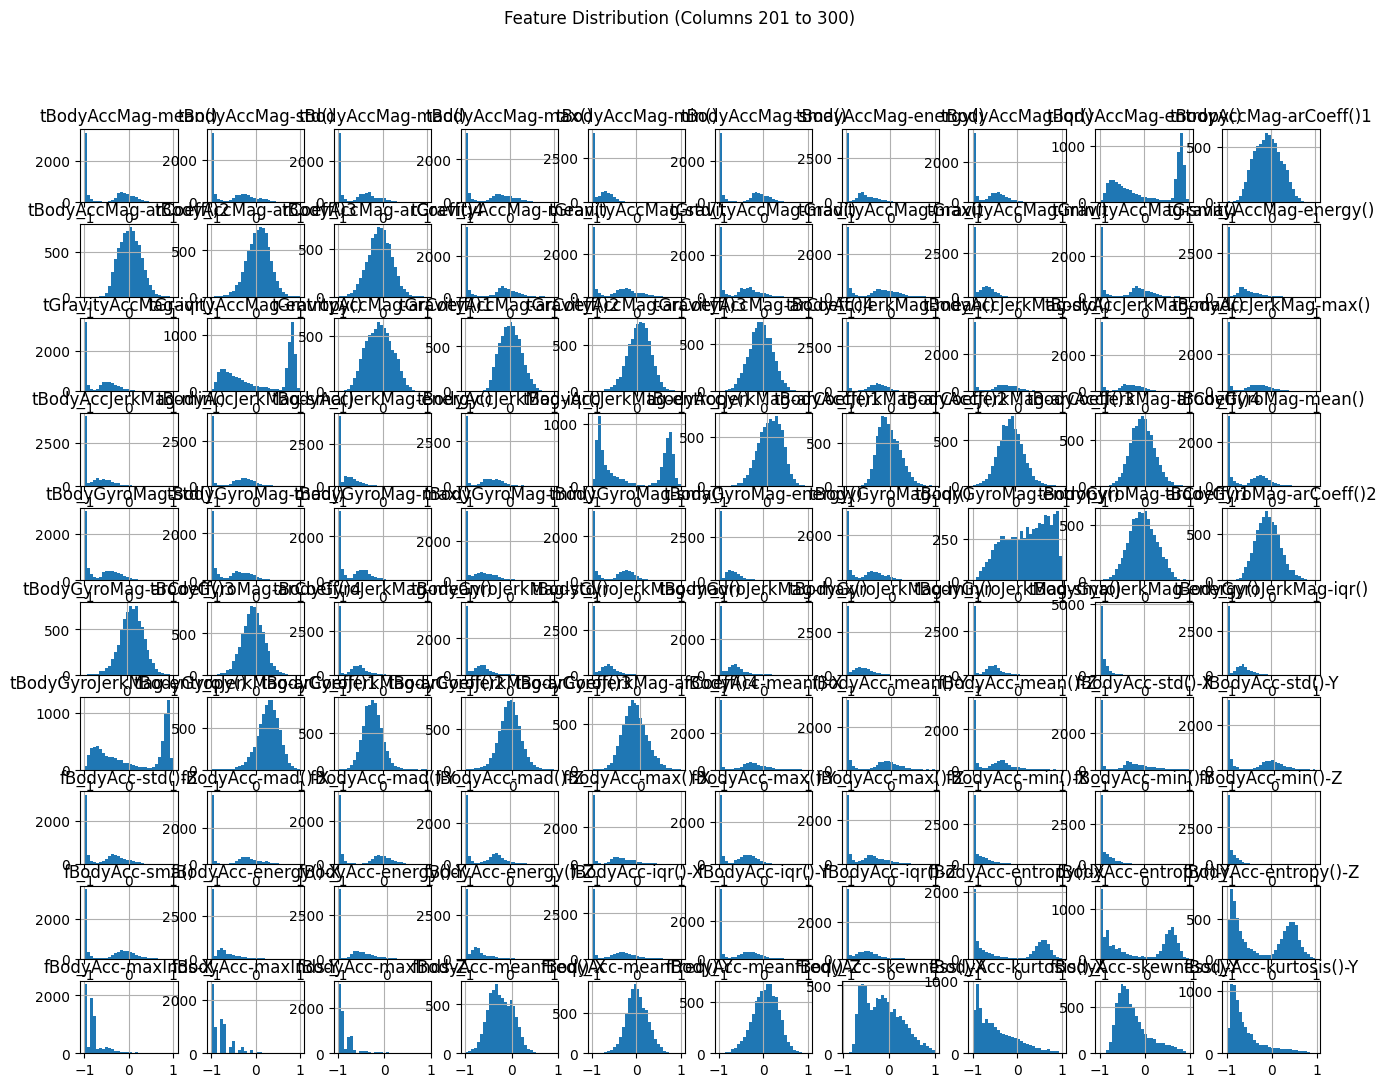

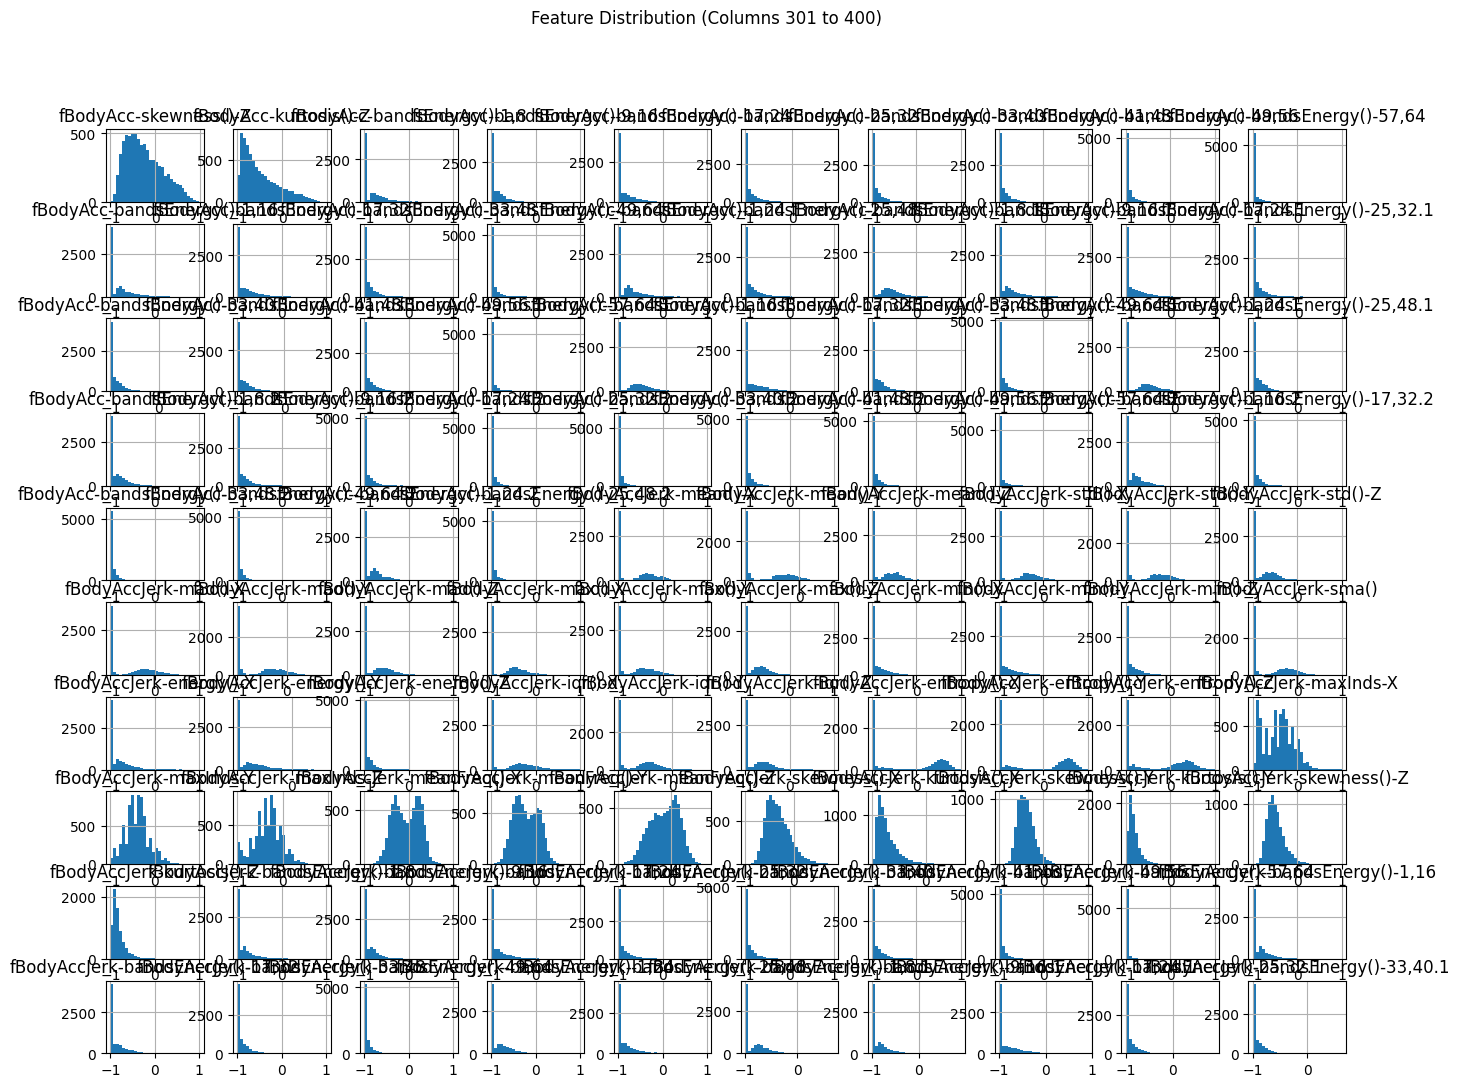

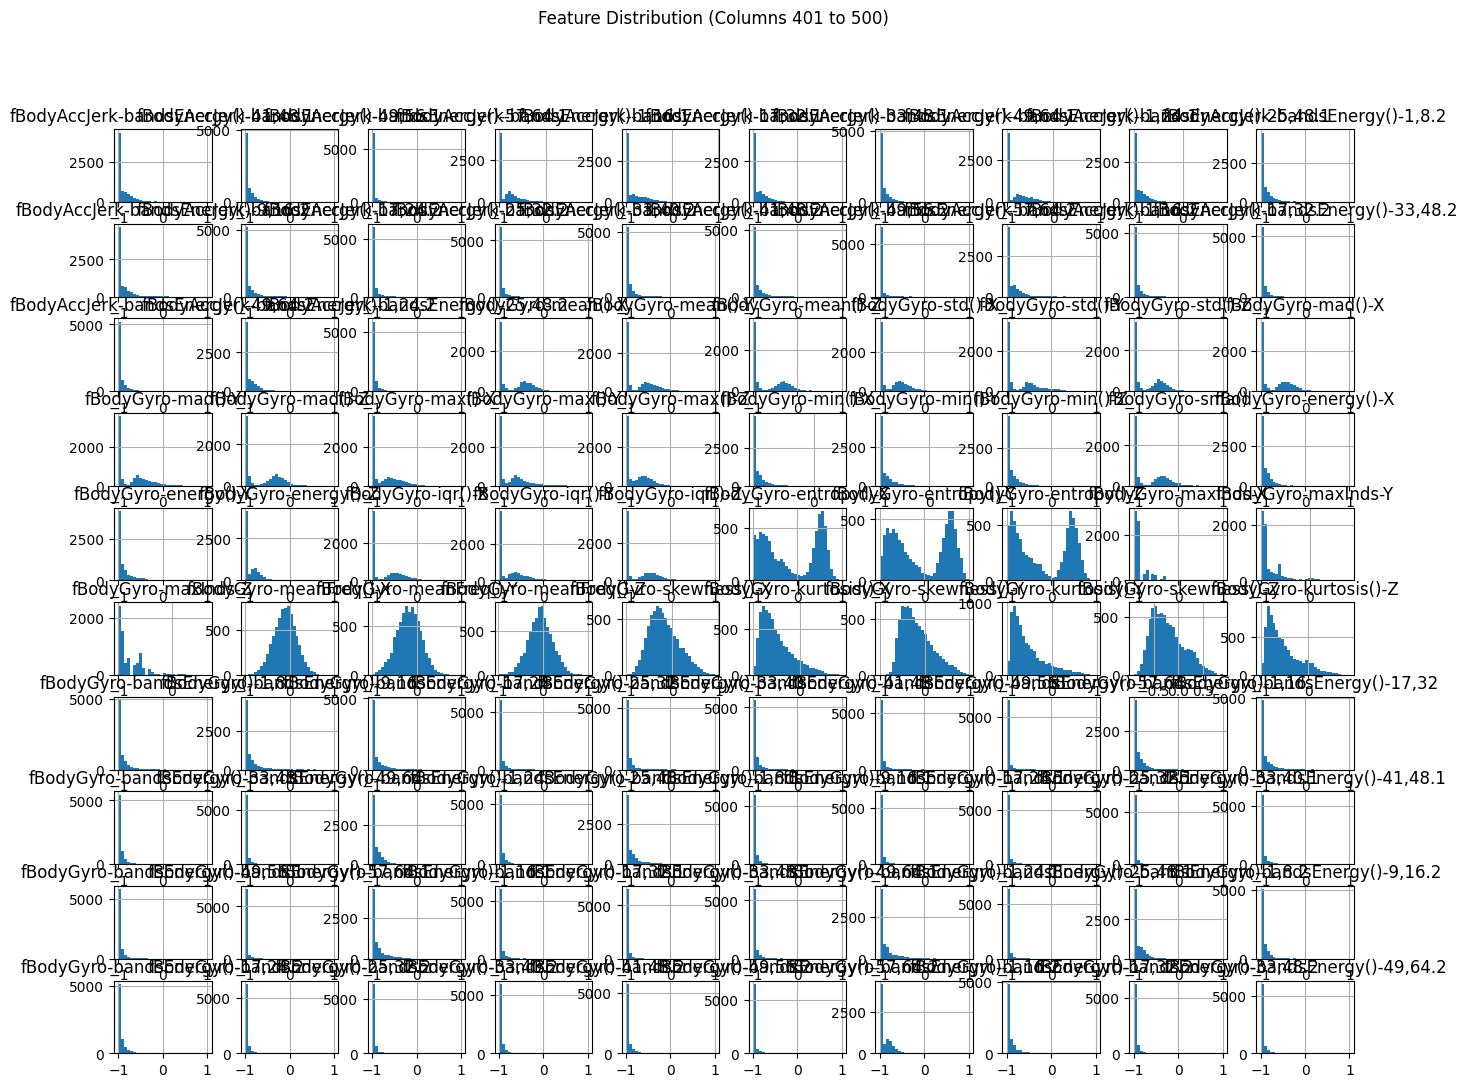

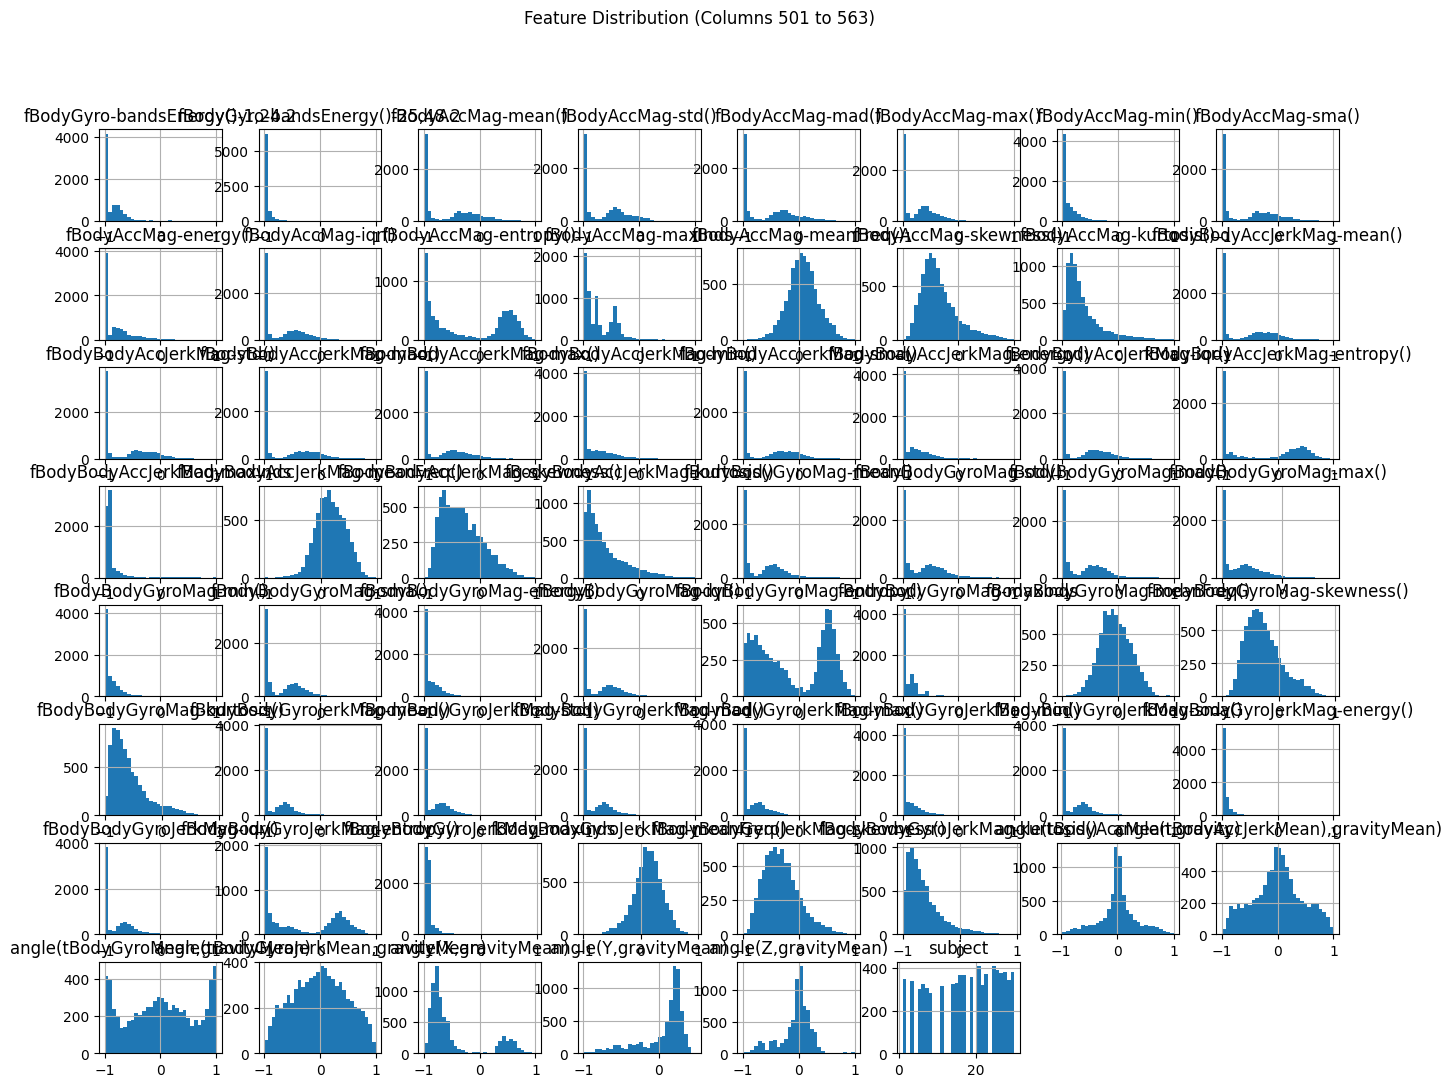

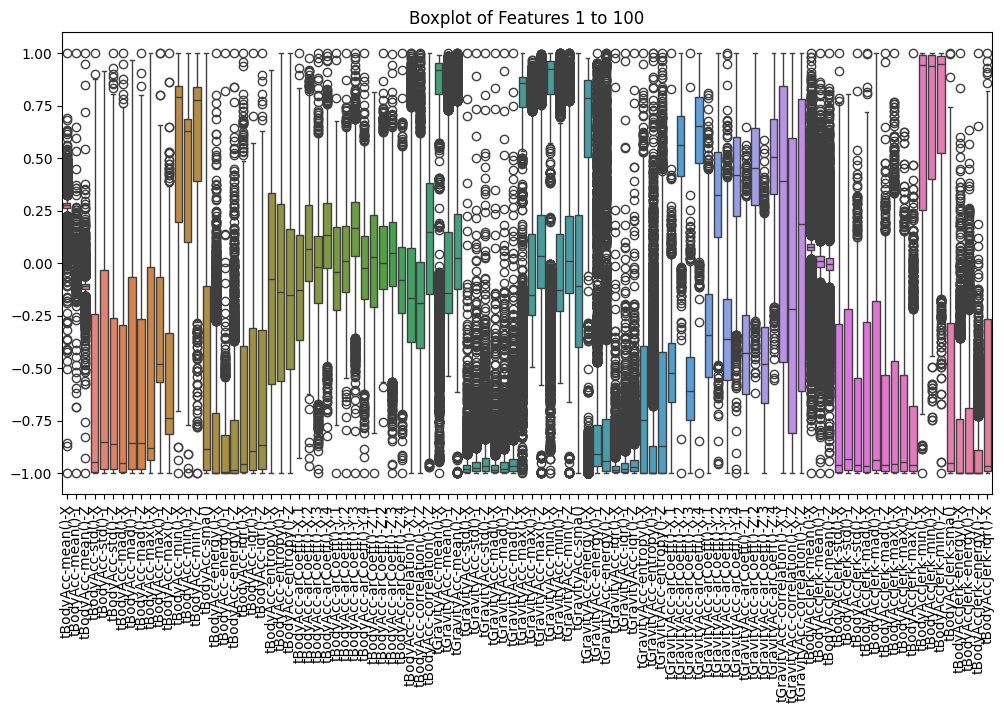

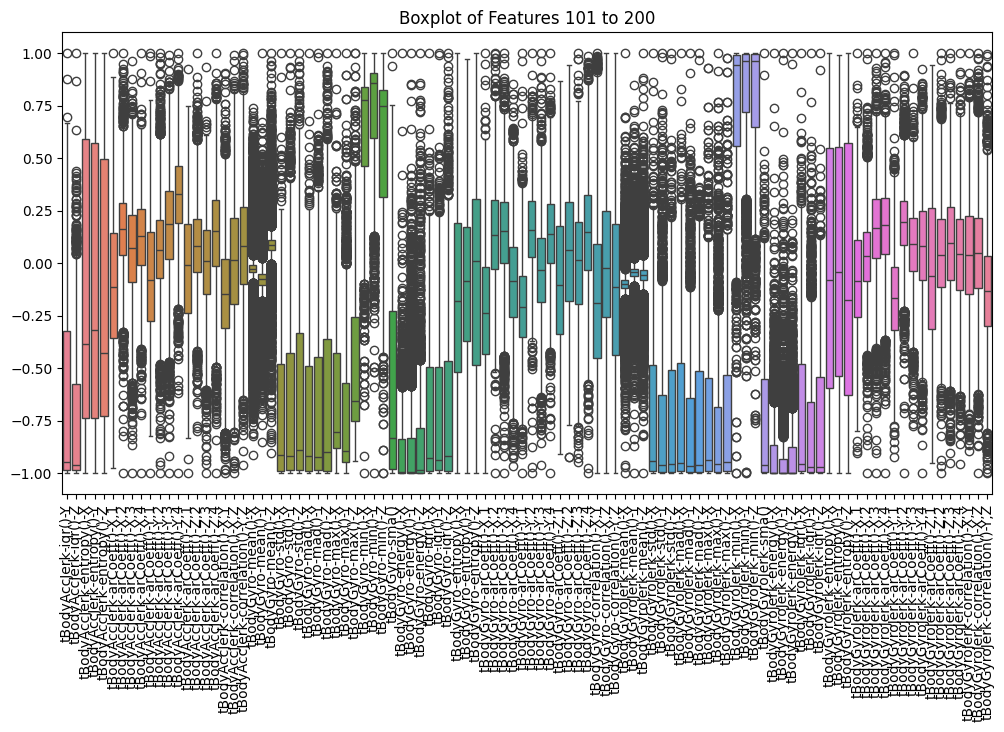

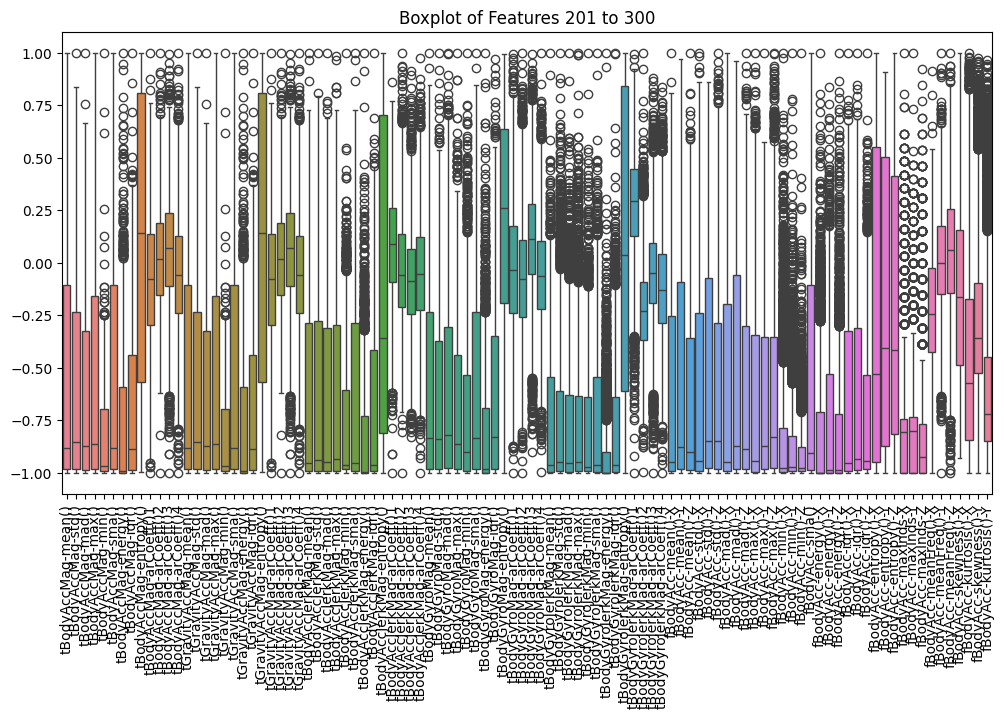

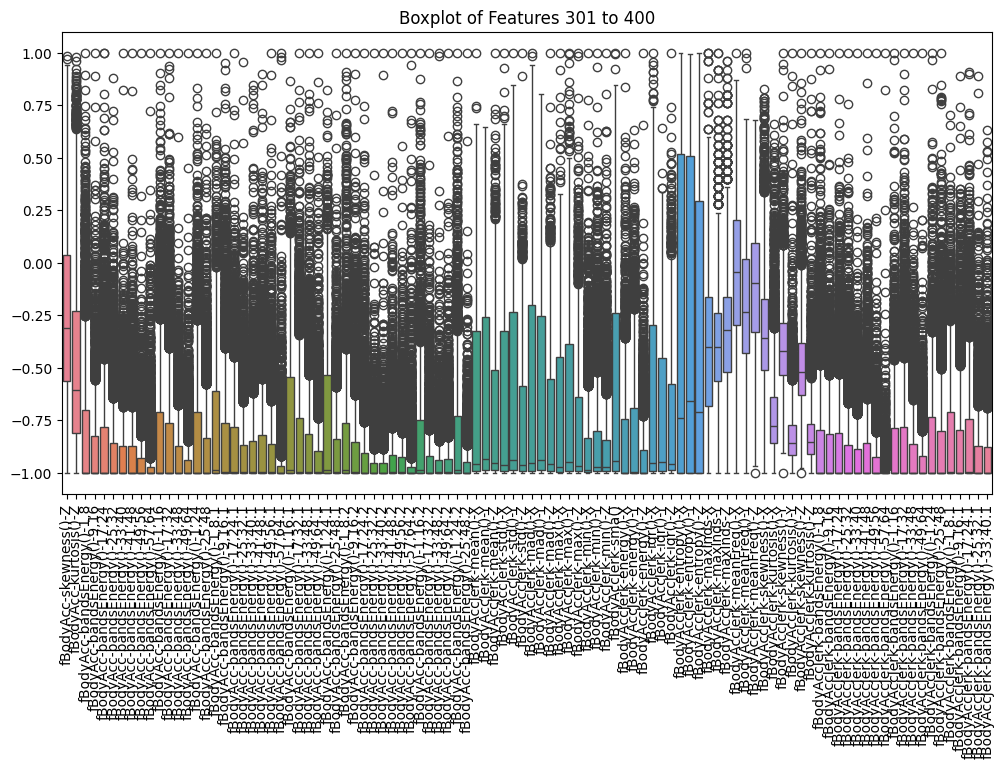

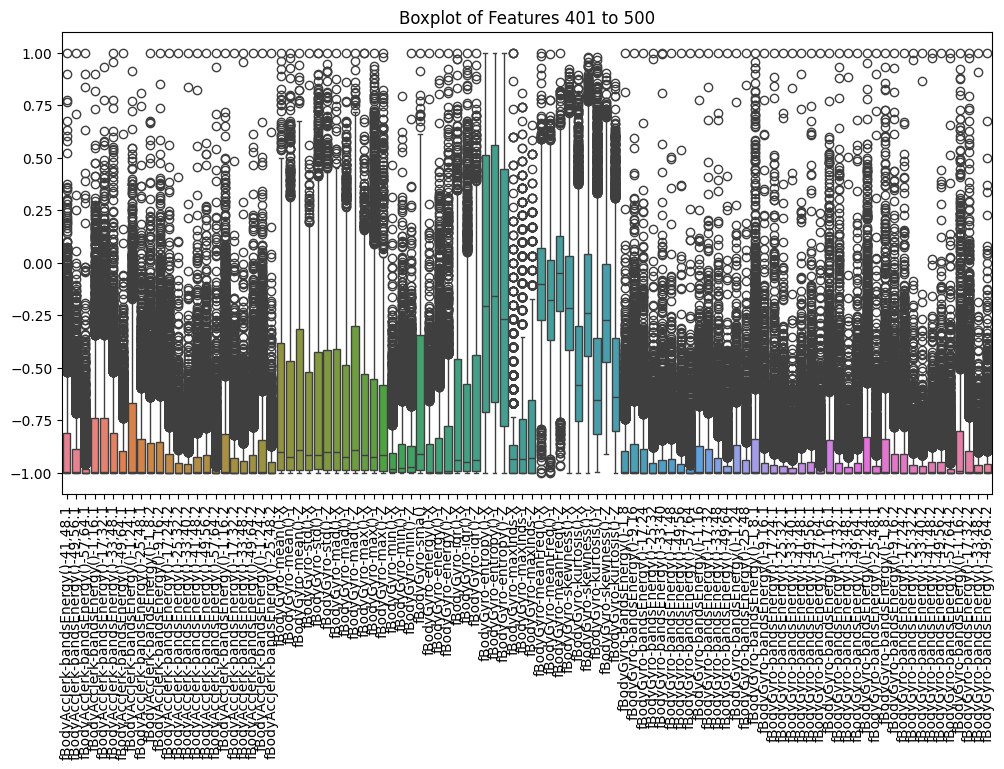

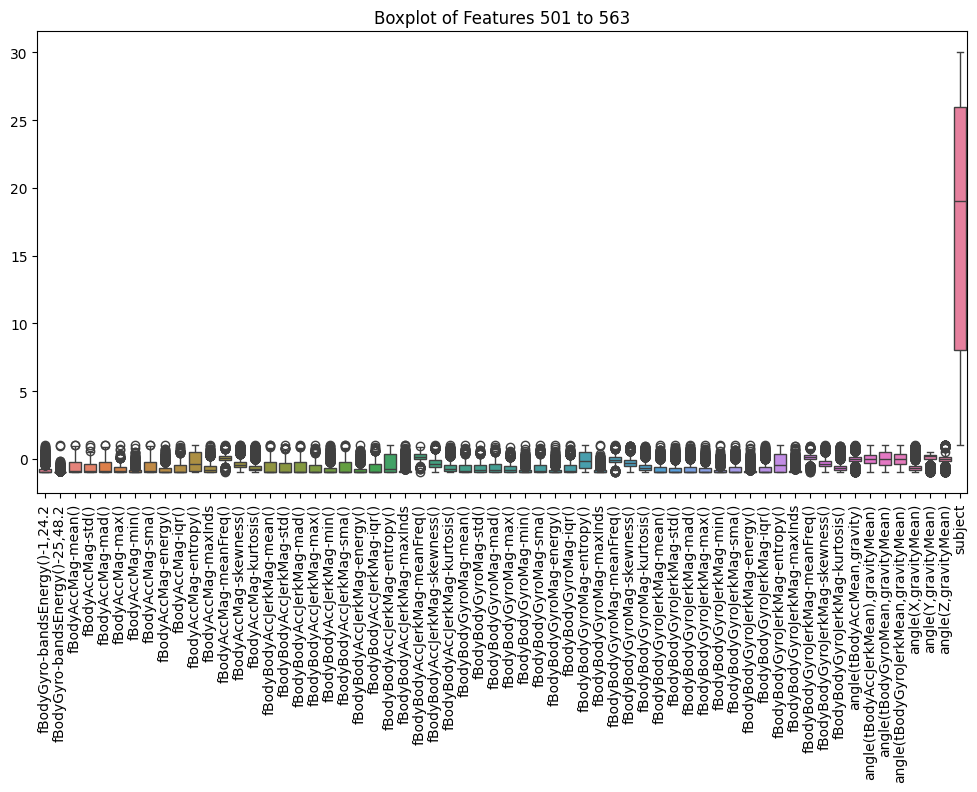


--- Preprocessing Data ---
Removing 256 highly correlated features: ['tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-sma()', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tGravityAcc-mad()-X', 'tGravityAcc-mad()-Y', 'tGravityAcc-mad()-Z', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-max()-Z', 'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-min()-Z', 'tGravityAcc-energy()-X', 'tGravityAcc-iqr()-X', 'tGravityAcc-iqr()-Y', 'tGravityAcc-iqr()-Z', 'tGravityAcc-arCoeff()-X,2', 'tGravityAcc-arCoeff()-X,3', 'tGravityAcc-arCoeff()-X,4', 'tGravityAcc-arCoeff()-Y,2', 'tGravityAcc-arCoeff()-Y,3', 'tGravityAcc-arCoeff()-Y,4', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Z,3', 'tGravityAcc-arCoeff()-Z,4', 'tBodyAccJerk-std()-X', 'tBodyAccJerk-mad()-X', 'tBodyAccJerk-mad()-Y', 'tBodyAccJerk-mad()-Z', 'tBodyAccJerk-sma()', 'tBodyAccJerk-iqr()-X', 'tBodyAccJerk-iqr()-Y', 'tBodyAccJerk-iqr()-Z', 'tBodyAccJerk-entro

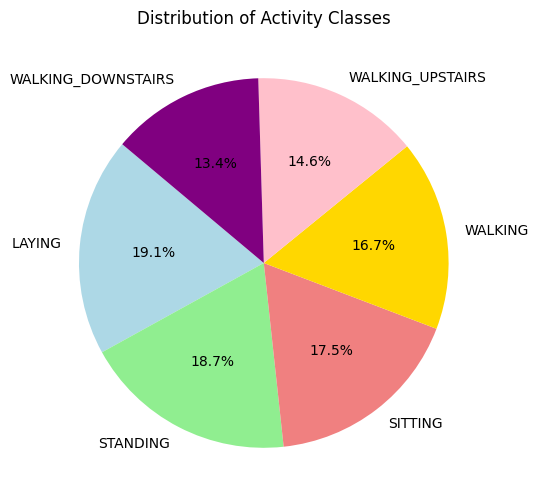

In [81]:
# Load data
train, test = load_data(train_path, test_path)

# Perform EDA
EDA_check(train, test)

# Preprocess data
X_train, y_train, X_test, y_test, scaler, pca, activity_encoder, subject_encoder = data_preprocessing(train, test)


#X_train_final, y_train, X_test_final, y_test, scaler, pca, activity_encoder, subject_encoder = data_preprocessing(train, test)


In [91]:
X_train_input = X_train
y_train_input = y_train
X_test_input = X_test
y_test_input = y_test
scaler_input = scaler
pca_input=pca
encoder_input=subject_encoder
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("X_train_input shape:", X_train_input.shape)
print("y_train_input shape:", y_train_input.shape)
print("X_test_input shape:", X_test_input.shape)
print("y_test_input shape:", y_test_input.shape)

X_train shape: (8442, 131)
y_train shape: (8442,)
X_test shape: (2947, 131)
y_test shape: (2947,)
X_train_input shape: (8442, 131)
y_train_input shape: (8442,)
X_test_input shape: (2947, 131)
y_test_input shape: (2947,)


In [92]:
# Traing and evaluate RandomForest Model

In [93]:
y_train_input

array([2, 2, 2, ..., 5, 5, 5])

In [ ]:
# Traing and evaluate RandomForest Model


--- Training and Evaluating RandomForest Model ---
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest model initialized with tuned hyperparameters.
Cross-validation accuracy scores: [0.95677916 0.97276495 0.9549763  0.95734597 0.96445498]
Mean cross-validation accuracy: 0.9613
RandomForest model trained on the full training set.
Model trained.
Predictions made on the test set.
Test Accuracy: 90.84%
Test F1-score: 0.9079
Test Precision: 0.9094
Test Recall: 0.9084

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       537
           1       0.88      0.82      0.85       491
           2       0.85      0.91      0.88       532
           3       0.88      0.97      0.93       496
           4       0.93      0.84      0.88       420
           5       0.92      0.91      0.91       471

    accuracy                           0.91      2947
   macro avg       0.91    

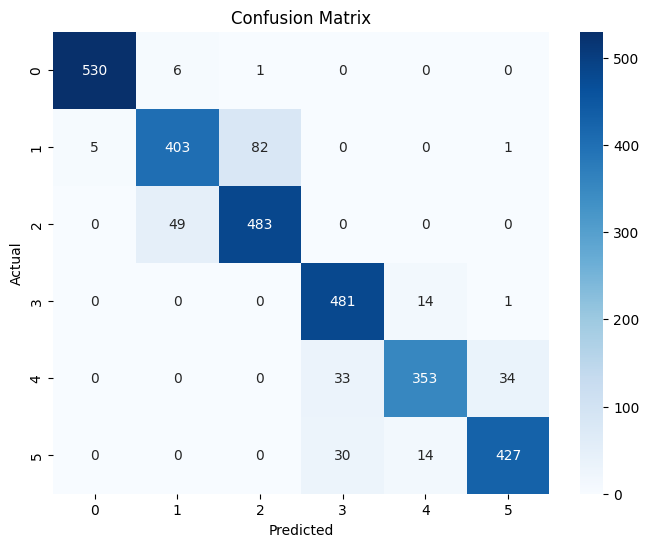

Model evaluated.


In [94]:
model_random_forest, y_pred_random_forest = randomforest_model_training_and_evaluation("RandomForest", X_train_input, y_train_input, X_test_input, y_test_input)

In [96]:
# Ensure X_train and y_train have the correct shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# The model outputs probabilities, converting into class labels
if y_pred_random_forest.ndim > 1:
    y_pred_random_forest = y_pred_random_forest.argmax(axis=1)

# Mapping predicted labels to target names
predicted_target_names = [target_names[i] for i in y_pred_random_forest]

# Mapping original labels to target names
original_target_names = [target_names[i] for i in y_test]

# Printing top 2 predictions at an offset of 100, repeating 10 times
offset = 100
num_samples = 2
num_offsets = 10

print(f"Top {num_samples} Predictions at Offset of {offset} (Repeated {num_offsets} Times):")
for i in range(num_offsets):
    start_idx = i * offset
    end_idx = start_idx + num_samples
    print(f"\nOffset {start_idx} to {end_idx - 1}:")
    for j in range(start_idx, end_idx):
        print(f"Sample {j}: Predicted = {predicted_target_names[j]}, Original = {original_target_names[j]}")

X_train shape: (8442, 131)
y_train shape: (8442,)
Top 2 Predictions at Offset of 100 (Repeated 10 Times):

Offset 0 to 1:
Sample 0: Predicted = LAYING, Original = LAYING
Sample 1: Predicted = LAYING, Original = LAYING

Offset 100 to 101:
Sample 100: Predicted = WALKING, Original = WALKING
Sample 101: Predicted = WALKING, Original = WALKING

Offset 200 to 201:
Sample 200: Predicted = SITTING, Original = SITTING
Sample 201: Predicted = SITTING, Original = SITTING

Offset 300 to 301:
Sample 300: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS
Sample 301: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS

Offset 400 to 401:
Sample 400: Predicted = WALKING, Original = WALKING
Sample 401: Predicted = WALKING, Original = WALKING

Offset 500 to 501:
Sample 500: Predicted = SITTING, Original = SITTING
Sample 501: Predicted = SITTING, Original = SITTING

Offset 600 to 601:
Sample 600: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS
Sample 601: Predicted = WALKING_UPST

In [98]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [99]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [100]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [101]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [102]:
def svm_tune_hyperparameters(X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV."""
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
    grid_search = GridSearchCV(
        SVC(random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

def cross_validate(model, X_train, y_train):
    """Perform cross-validation on the training data."""
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return cv_scores

def svm_model_training_and_evaluation(X_train, y_train, X_test, y_test, algorithm_name="SVM"):
    """Train, evaluate, and save an SVM model."""
    print(f"Training {algorithm_name} model...")

    # Hyperparameter tuning
    print("Starting hyperparameter tuning...")
    best_model = svm_tune_hyperparameters(X_train, y_train)
    print("Hyperparameter tuning completed.")

    # Initialize the model
    model_svm = SVC(
        C=best_model.C,
        kernel=best_model.kernel,
        random_state=42,
        probability=True  # Enable probability estimates
    )
    print(f"{algorithm_name} model initialized with tuned hyperparameters.")

    # Perform cross-validation
    logging.info("Performing cross-validation...")
    cv_scores = cross_validate(model_svm, X_train, y_train)
    print(f"Cross-validation accuracy scores: {cv_scores}")
    print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

    # Train the model
    model_svm.fit(X_train, y_train)
    print("Model trained.")

    #  predictions on the test set
    y_pred_svm = model_svm.predict(X_test)
    print("Predictions made on the test set.")

    # Evaluate the model
    evaluate_model(algorithm_name, y_test, y_pred_svm)
    print("Model evaluated.")

    return model_svm, y_pred_svm

In [103]:
# Ensure X_train and y_train have the correct shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (8442, 131)
y_train shape: (8442,)


In [ ]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [104]:
# Train and evaluate the SVM model

Training SVM model...
Starting hyperparameter tuning...
Best hyperparameters: {'C': 10, 'kernel': 'rbf'}
Hyperparameter tuning completed.
SVM model initialized with tuned hyperparameters.
Cross-validation accuracy scores: [0.98046181 0.97039668 0.98163507 0.98459716 0.96327014]
Mean cross-validation accuracy: 0.9761
Model trained.
Predictions made on the test set.
Test Accuracy: 94.74%
Test F1-score: 0.9472
Test Precision: 0.9482
Test Recall: 0.9474

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.94      0.87      0.90       491
           2       0.89      0.95      0.92       532
           3       0.94      0.98      0.96       496
           4       0.97      0.93      0.95       420
           5       0.96      0.95      0.95       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95 

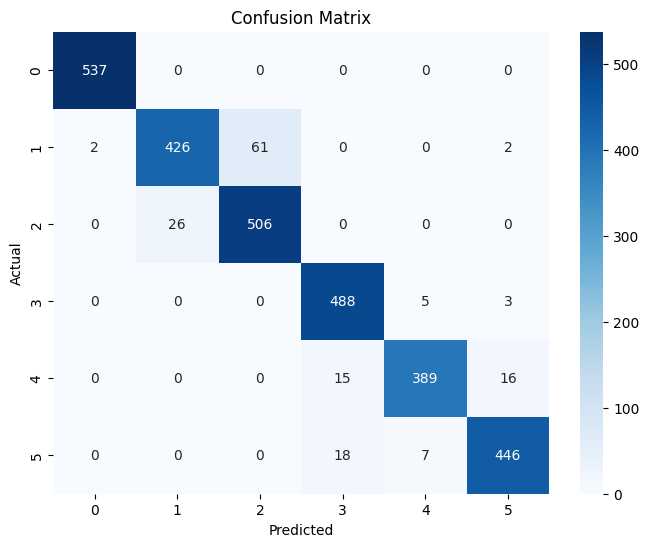

Model evaluated.


In [105]:
model_svm, y_pred_svm = svm_model_training_and_evaluation(X_train, y_train, X_test, y_test)

In [107]:
# Ensure X_train and y_train have the correct shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# The model outputs probabilities, converting into class labels
if y_pred_svm.ndim > 1:
    y_pred_svm = y_pred_svm.argmax(axis=1)

# Mapping predicted labels to target names
predicted_target_names = [target_names[i] for i in y_pred_svm]

# Mapping original labels to target names
original_target_names = [target_names[i] for i in y_test]

# Printing top 2 predictions at an offset of 100, repeating 10 times
offset = 100
num_samples = 2
num_offsets = 10

print(f"Top {num_samples} Predictions at Offset of {offset} (Repeated {num_offsets} Times):")
for i in range(num_offsets):
    start_idx = i * offset
    end_idx = start_idx + num_samples
    print(f"\nOffset {start_idx} to {end_idx - 1}:")
    for j in range(start_idx, end_idx):
        print(f"Sample {j}: Predicted = {predicted_target_names[j]}, Original = {original_target_names[j]}")

X_train shape: (8442, 131)
y_train shape: (8442,)
Top 2 Predictions at Offset of 100 (Repeated 10 Times):

Offset 0 to 1:
Sample 0: Predicted = LAYING, Original = LAYING
Sample 1: Predicted = LAYING, Original = LAYING

Offset 100 to 101:
Sample 100: Predicted = WALKING, Original = WALKING
Sample 101: Predicted = WALKING, Original = WALKING

Offset 200 to 201:
Sample 200: Predicted = SITTING, Original = SITTING
Sample 201: Predicted = SITTING, Original = SITTING

Offset 300 to 301:
Sample 300: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS
Sample 301: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS

Offset 400 to 401:
Sample 400: Predicted = WALKING, Original = WALKING
Sample 401: Predicted = WALKING, Original = WALKING

Offset 500 to 501:
Sample 500: Predicted = SITTING, Original = SITTING
Sample 501: Predicted = SITTING, Original = SITTING

Offset 600 to 601:
Sample 600: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS
Sample 601: Predicted = WALKING_UPST

In [108]:
# LR Schedule

In [109]:
def lr_schedule(epoch):
    #Learning rate schedule for the CNN model.
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

In [110]:
# CNN Evalute Model

In [111]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [112]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [113]:
# -----------------------------------------------------------------------------------------------------------------------------------

In [114]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Class distribution in y_train:", dict(zip(unique_classes, class_counts)))

Class distribution in y_train: {np.int64(0): np.int64(1407), np.int64(1): np.int64(1407), np.int64(2): np.int64(1407), np.int64(3): np.int64(1407), np.int64(4): np.int64(1407), np.int64(5): np.int64(1407)}


In [115]:
subject_encoder

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [116]:
# Reshape X_train and X_test to 3D (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=-1)  # Shape: (samples, timesteps, 1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)    # Shape: (samples, timesteps, 1)
# X_train_final, y_train, X_test_final, y_test

# Convert features to float32
X_train_reshaped = X_train_reshaped.astype('float32')
X_test_reshaped = X_test_reshaped.astype('float32')

# Verify the conversion
print("X_train_reshaped shape:", X_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)
print("NaN in X_train:", np.isnan(X_train_reshaped).sum())
print("NaN in X_test:", np.isnan(X_test_reshaped).sum())

# Define input shape and number of classes
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
num_classes = len(np.unique(y_train))  # Number of unique classes in y_train
print("Input shape:", input_shape)
print("Number of classes:", num_classes)

X_train_reshaped shape: (8442, 131, 1)
X_test_reshaped shape: (2947, 131, 1)
NaN in X_train: 0
NaN in X_test: 0
Input shape: (131, 1)
Number of classes: 6


In [117]:
# Build an improved CNN-LSTM model
def build_improved_hybrid_model(input_shape, num_classes):
    """Build an improved CNN-LSTM model."""
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),
        
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),
        
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        
        LSTM(32),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [119]:
# Build the model
model_hybrid_lstm = build_improved_hybrid_model(input_shape, num_classes)
model_hybrid_lstm.summary()

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_hybrid_lstm.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model_hybrid_lstm.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
y_pred_hybrid_lstm = model_hybrid_lstm.predict(X_test_reshaped).argmax(axis=1)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_hybrid_lstm))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_hybrid_lstm))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 129, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 129, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 62, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 31, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,310 (352.77 KB)

 Trainable params: 89,798 (350.77 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1906 - loss: 2.1328 - val_accuracy: 0.0746 - val_loss: 2.2052
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2149 - loss: 1.8321 - val_accuracy: 0.0746 - val_loss: 3.5030
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2482 - loss: 1.7100 - val_accuracy: 0.2202 - val_loss: 1.6901
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3386 - loss: 1.3455 - val_accuracy: 0.3132 - val_loss: 1.1141
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4655 - loss: 1.0892 - val_accuracy: 0.3600 - val_loss: 1.0358
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5459 - loss: 0.9148 - val_accuracy: 0.4446 - val_loss: 0.9556
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5901 - loss: 0.7981 - val_accuracy: 0.6619 - val_loss: 0.7322
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6272 - loss: 0.7389 - val_accu

In [121]:
# Ensure X_train and y_train have the correct shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# The model outputs probabilities, converting into class labels
if y_pred_hybrid_lstm.ndim > 1:
    y_pred_hybrid_lstm = y_pred_hybrid_lstm.argmax(axis=1)

# Mapping predicted labels to target names
predicted_target_names = [target_names[i] for i in y_pred_hybrid_lstm]

# Mapping original labels to target names
original_target_names = [target_names[i] for i in y_test]

# Printing top 2 predictions at an offset of 100, repeating 10 times
offset = 100
num_samples = 2
num_offsets = 10

print(f"Top {num_samples} Predictions at Offset of {offset} (Repeated {num_offsets} Times):")
for i in range(num_offsets):
    start_idx = i * offset
    end_idx = start_idx + num_samples
    print(f"\nOffset {start_idx} to {end_idx - 1}:")
    for j in range(start_idx, end_idx):
        print(f"Sample {j}: Predicted = {predicted_target_names[j]}, Original = {original_target_names[j]}")

X_train shape: (8442, 131)
y_train shape: (8442,)
Top 2 Predictions at Offset of 100 (Repeated 10 Times):

Offset 0 to 1:
Sample 0: Predicted = LAYING, Original = LAYING
Sample 1: Predicted = LAYING, Original = LAYING

Offset 100 to 101:
Sample 100: Predicted = WALKING, Original = WALKING
Sample 101: Predicted = WALKING, Original = WALKING

Offset 200 to 201:
Sample 200: Predicted = SITTING, Original = SITTING
Sample 201: Predicted = SITTING, Original = SITTING

Offset 300 to 301:
Sample 300: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS
Sample 301: Predicted = WALKING_DOWNSTAIRS, Original = WALKING_UPSTAIRS

Offset 400 to 401:
Sample 400: Predicted = WALKING, Original = WALKING
Sample 401: Predicted = WALKING, Original = WALKING

Offset 500 to 501:
Sample 500: Predicted = SITTING, Original = SITTING
Sample 501: Predicted = SITTING, Original = SITTING

Offset 600 to 601:
Sample 600: Predicted = WALKING_DOWNSTAIRS, Original = WALKING_UPSTAIRS
Sample 601: Predicted = WALKING_

In [122]:
# Build CNN Model

In [124]:
def cnn_model_training_and_evaluation(X_train, y_train, X_test, y_test):
    """
    Train and evaluate a CNN model.

    Parameters:
        X_train (np.array): Training data features.
        y_train (np.array): Training data labels.
        X_test (np.array): Test data features.
        y_test (np.array): Test data labels.

    Returns:
        model: Trained CNN model.
    """
    # Reshape data for CNN input
    X_train_reshaped = np.expand_dims(X_train, axis=-1)  # Shape: (samples, timesteps, 1)
    X_test_reshaped = np.expand_dims(X_test, axis=-1)    # Shape: (samples, timesteps, 1)

    # Define input shape and number of classes
    input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
    num_classes = len(np.unique(y_train))  # Number of unique classes in y_train
    print("Input shape:", input_shape)
    print("Number of classes:", num_classes)

    # Build the CNN model
    def build_cnn_model(input_shape, num_classes):
        """Build a CNN model."""
        model = Sequential([
            Conv1D(64, 3, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling1D(2),
            Dropout(0.3),
            
            Conv1D(128, 3, activation='relu'),
            BatchNormalization(),
            MaxPooling1D(2),
            Dropout(0.3),
            
            Conv1D(256, 3, activation='relu'),
            BatchNormalization(),
            MaxPooling1D(2),
            Dropout(0.3),
            
            Flatten(),
            
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    # Build the model
    model = build_cnn_model(input_shape, num_classes)
    model.summary()

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_reshaped, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Make predictions
    y_pred_cnn = model.predict(X_test_reshaped).argmax(axis=1)

    # Classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(y_test, y_pred_cnn))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_cnn))

    return model, y_pred_cnn

In [125]:
# Ensure X_train and y_train have the correct shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Train and evaluate the SVM model
cnn_model, y_pred_cnn = cnn_model_training_and_evaluation(X_train, y_train, X_test, y_test)

X_train shape: (8442, 131)
y_train shape: (8442,)
Input shape: (131, 1)
Number of classes: 6


/Users/dheerajkumar/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 129, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 129, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 62, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 62, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 29, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 29, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       458,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 585,478 (2.23 MB)

 Trainable params: 584,326 (2.23 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4922 - loss: 1.5138 - val_accuracy: 0.2268 - val_loss: 3.6007
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8119 - loss: 0.4800 - val_accuracy: 0.3363 - val_loss: 2.2756
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8788 - loss: 0.3054 - val_accuracy: 0.9147 - val_loss: 0.2392
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9064 - loss: 0.2418 - val_accuracy: 0.9609 - val_loss: 0.1103
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9213 - loss: 0.2053 - val_accuracy: 0.9745 - val_loss: 0.0736
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9341 - loss: 0.1767 - val_accuracy: 0.9769 - val_loss: 0.0641
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9481 - loss: 0.1399 - val_accuracy: 0.9828 - val_loss: 0.0599
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9515 - loss: 0.1356 - val_accu

In [127]:
# Ensure X_train and y_train have the correct shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# The model outputs probabilities, converting into class labels
if y_pred_cnn.ndim > 1:
    y_pred_cnn = y_pred_cnn.argmax(axis=1)

# Mapping predicted labels to target names
predicted_target_names = [target_names[i] for i in y_pred_cnn]

# Mapping original labels to target names
original_target_names = [target_names[i] for i in y_test]

# Printing top 2 predictions at an offset of 100, repeating 10 times
offset = 100
num_samples = 2
num_offsets = 10

print(f"Top {num_samples} Predictions at Offset of {offset} (Repeated {num_offsets} Times):")
for i in range(num_offsets):
    start_idx = i * offset
    end_idx = start_idx + num_samples
    print(f"\nOffset {start_idx} to {end_idx - 1}:")
    for j in range(start_idx, end_idx):
        print(f"Sample {j}: Predicted = {predicted_target_names[j]}, Original = {original_target_names[j]}")

X_train shape: (8442, 131)
y_train shape: (8442,)
Top 2 Predictions at Offset of 100 (Repeated 10 Times):

Offset 0 to 1:
Sample 0: Predicted = LAYING, Original = LAYING
Sample 1: Predicted = LAYING, Original = LAYING

Offset 100 to 101:
Sample 100: Predicted = WALKING, Original = WALKING
Sample 101: Predicted = WALKING, Original = WALKING

Offset 200 to 201:
Sample 200: Predicted = SITTING, Original = SITTING
Sample 201: Predicted = SITTING, Original = SITTING

Offset 300 to 301:
Sample 300: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS
Sample 301: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS

Offset 400 to 401:
Sample 400: Predicted = WALKING, Original = WALKING
Sample 401: Predicted = WALKING, Original = WALKING

Offset 500 to 501:
Sample 500: Predicted = SITTING, Original = SITTING
Sample 501: Predicted = SITTING, Original = SITTING

Offset 600 to 601:
Sample 600: Predicted = WALKING_UPSTAIRS, Original = WALKING_UPSTAIRS
Sample 601: Predicted = WALKING_UPST